In [21]:
%%time

#!/usr/bin/python
# -*- coding: utf-8 -*-
# Author: Selvaria
# IEEE-CIS
# https://www.kaggle.com/xhlulu/ieee-fraud-xgboost-with-gpu-fit-in-40s

import os

import numpy as np
import pandas as pd

#这里将TransactionID设为index是为了合并时能够将二者的数据全部保存到一个表里，不会错漏
train_transaction = pd.read_csv('d:/data/Kaggle/IEEE-CIS/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('d:/data/Kaggle/IEEE-CIS/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('d:/data/Kaggle/IEEE-CIS/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('d:/data/Kaggle/IEEE-CIS/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('d:/data/Kaggle/IEEE-CIS/sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

(590540, 433)
(506691, 432)
Wall time: 45.6 s


In [4]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [22]:
y_train = train['isFraud'].copy()
print(y_train.shape)
y_train.head()

(590540,)


TransactionID
2987000    0
2987001    0
2987002    0
2987003    0
2987004    0
Name: isFraud, dtype: int64

In [23]:
#统计只有一个值的列
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1] #nunique()用于获取列唯一值的统计数量，注意默认去掉了null值
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
print(one_value_cols)
print(one_value_cols_test)

[]
['V107']


In [24]:
#空值过多的列

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.95]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.95]

print(many_null_cols)
print(many_null_cols_test)

['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [25]:
#单一值过多的列

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.95]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.95]
print(big_top_value_cols)
print(len(big_top_value_cols))
print(big_top_value_cols_test)
print(len(big_top_value_cols_test))

['isFraud', 'C3', 'V104', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V125', 'V135', 'V281', 'V286', 'V297', 'V300', 'V301', 'V305', 'V311', 'V319', 'id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
39
['C3', 'V14', 'V25', 'V26', 'V27', 'V28', 'V65', 'V66', 'V68', 'V88', 'V89', 'V98', 'V101', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V125', 'V129', 'V132', 'V286', 'V305', 'V311', 'id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
45


In [26]:
cols_to_drop = list(set(many_null_cols + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
print(cols_to_drop)
len(cols_to_drop)

['V123', 'id_23', 'id_07', 'V297', 'V111', 'V112', 'V281', 'V25', 'V120', 'V305', 'V108', 'V119', 'V88', 'V300', 'V129', 'id_22', 'V26', 'id_26', 'V101', 'V98', 'V110', 'V286', 'V14', 'V68', 'C3', 'id_08', 'id_24', 'V132', 'V113', 'V114', 'V109', 'id_27', 'V125', 'V28', 'V121', 'V122', 'id_21', 'V301', 'V115', 'V311', 'V116', 'V117', 'V66', 'V319', 'V107', 'V65', 'V118', 'V89', 'V135', 'V104', 'id_25', 'V27']


52

In [27]:
#删掉不必须的列

del train_transaction, train_identity, test_transaction, test_identity

# Drop target not needed, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_train = X_train.drop(cols_to_drop, axis=1)
X_test = test.copy()
X_test = X_test.drop(cols_to_drop, axis=1)

X_train = X_train.fillna(-999) #为了模型能够识别
X_test = X_test.fillna(-999)

print(X_train.shape)
print(X_test.shape)

X_train.head()

(590540, 380)
(506691, 380)


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,W,13926,-999.0,150.0,discover,142.0,credit,315.0,...,-999,-999.0,-999,-999,-999,-999,-999,-999,-999,-999
2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,-999,-999.0,-999,-999,-999,-999,-999,-999,-999,-999
2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,-999,-999.0,-999,-999,-999,-999,-999,-999,-999,-999
2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,-999,-999.0,-999,-999,-999,-999,-999,-999,-999,-999
2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
#删掉一些表，节省内存
del train, test

In [31]:
%%time
#将出现次数过低的值替换为其他值

from tqdm import tqdm

def handle_cols(col_name, df=X_train, set_value=-9999):
    df_where = df[col_name].copy()
    df_con = df_where.value_counts(dropna=False, normalize=True)
    #print(df_con)
    #test_v = df_con.values
    #print(df_con[df_con==test_v[1]].index.tolist()[0])
    for index in df_where.index:
        col_val = df_where.loc[index]
        if df_con.loc[col_val]<0.02:
            df_where.loc[index] = set_value
        else:
            continue
    return list(df_where)


for col in tqdm(X_train.columns): 
    print(f'now is {col};')
    X_train[col] = handle_cols(col)
    X_test[col] = handle_cols(col)
    
X_train.head()



  0%|                                                                                          | 0/380 [00:00<?, ?it/s]

now is TransactionDT;


KeyboardInterrupt: 

In [32]:
%%time
# Label Encoding

from sklearn import preprocessing

for f in X_train.columns: #按列遍历，将文字数字化
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))
    

X_test.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.95,4,10409,111.0,150.0,4,226.0,3,170.0,...,0,-999.0,0,0,0,0,0,0,0,0
3663550,18403263,49.00,4,4272,111.0,150.0,4,226.0,3,299.0,...,0,-999.0,0,0,0,0,0,0,0,0
3663551,18403310,171.00,4,4476,574.0,150.0,4,226.0,3,472.0,...,0,-999.0,0,0,0,0,0,0,0,0
3663552,18403310,284.95,4,10989,360.0,150.0,4,166.0,3,205.0,...,0,-999.0,0,0,0,0,0,0,0,0
3663553,18403317,67.95,4,18018,452.0,150.0,3,117.0,3,264.0,...,0,-999.0,0,0,0,0,0,0,0,0


In [8]:
%%time
#GridSearchCV调参
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import gc

gc.collect()

model = xgb.XGBClassifier(objective='binary:logistic',missing=-999,random_state=1949)
cv_params = {
    #'gamma': [0, 0.5],
    #"max_depth": [8,9,10],
    "learning_rate": [0.01,0.05],
    'n_estimators': [100,200,500]
}

optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=5,
                             verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.grid_scores_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 257.9min finished


每轮迭代运行结果:[mean: 0.97025, std: 0.00039, params: {'learning_rate': 0.01, 'n_estimators': 100}, mean: 0.97071, std: 0.00033, params: {'learning_rate': 0.01, 'n_estimators': 200}, mean: 0.97153, std: 0.00034, params: {'learning_rate': 0.01, 'n_estimators': 500}, mean: 0.97154, std: 0.00034, params: {'learning_rate': 0.05, 'n_estimators': 100}, mean: 0.97282, std: 0.00056, params: {'learning_rate': 0.05, 'n_estimators': 200}, mean: 0.97400, std: 0.00078, params: {'learning_rate': 0.05, 'n_estimators': 500}]
参数的最佳取值：{'learning_rate': 0.05, 'n_estimators': 500}
最佳模型得分:0.9740000677346158
Wall time: 5h 17min 41s


D:\Selvaria\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [ ]:
%%time

gc.collect()

model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=500,
    learning_rate=0.05,
    missing=-999,
    random_state=1949,
)
cv_params = {
    'gamma': [0, 0.5],
    "max_depth": [8,9,10],
}

optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=5,
                             verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.grid_scores_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 1150.5min finished


In [34]:
#训练模型
#XGB
import xgboost as xgb

clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=700,
    max_depth=9,
    learning_rate=0.05,
    subsample=1, #样本采样率，0.9即90%作为训练集
    colsample_bytree=1, #列（特征值）采样率，0.9即90%的列作为特征值
    missing=-999,
    random_state=1989,
    silent = False
    #tree_method='gpu_hist'  # 开gpu用
)

In [35]:
%%time
clf.fit(X_train, y_train)

[16:45:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=9
[16:46:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=9
[16:46:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=9
[16:46:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=9
[16:47:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=9
[16:47:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=9
[16:47:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[17:15:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 0 pruned nodes, max_depth=9
[17:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=9
[17:16:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=9
[17:16:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 690 extra nodes, 0 pruned nodes, max_depth=9
[17:16:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=9
[17:17:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=9
[17:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[17:44:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=9
[17:44:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[17:44:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=9
[17:45:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=9
[17:45:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[17:45:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=9
[17:45:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[18:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=9
[18:12:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[18:13:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[18:13:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=9
[18:13:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[18:13:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[18:14:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[18:40:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=9
[18:40:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=9
[18:41:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=9
[18:41:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=9
[18:41:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=9
[18:41:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=9
[18:42:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[19:08:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=9
[19:08:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=9
[19:09:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=9
[19:09:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[19:09:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=9
[19:09:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=9
[19:10:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[19:36:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[19:37:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[19:37:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[19:37:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=9
[19:37:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[19:38:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=9
[19:38:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruni

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=-999, n_estimators=700,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=1989, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1)

In [38]:
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
#folds = KFold(n_splits=5)

# params = {'num_leaves': 256,
#           'min_child_samples': 79,
#           'objective': 'binary',
#           'max_depth': 13,
#           'learning_rate': 0.03,
#           "boosting_type": "gbdt",
#           "subsample_freq": 3,
#           "subsample": 0.9,
#           "bagging_seed": 11,
#           "metric": 'auc',
#           "verbosity": -1,
#           'reg_alpha': 0.3,
#           'reg_lambda': 0.3,
#           'colsample_bytree': 0.9,
#           #'categorical_feature': cat_cols
#          }

In [39]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [43]:
%%time
#lgb计算各个特征值的权重

feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train, y_train)):
    #start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y_train.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999969	valid_1's auc: 0.902878
Early stopping, best iteration is:
[973]	training's auc: 0.99996	valid_1's auc: 0.903001
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999808	valid_1's auc: 0.921342
Early stopping, best iteration is:
[905]	training's auc: 0.99963	valid_1's auc: 0.921691
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.998672	valid_1's auc: 0.912489
Early stopping, best iteration is:
[963]	training's auc: 0.998428	valid_1's auc: 0.912559
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.996256	valid_1's auc: 0.933179
Early stopping, best iteration is:
[1087]	training's auc: 0.997131	valid_1's auc: 0.933419
Training on fold 5
Training until validation scores don't improve for 500 rounds.
[1000]	

Text(0.5,1,'50 TOP feature importance over 5 folds average')

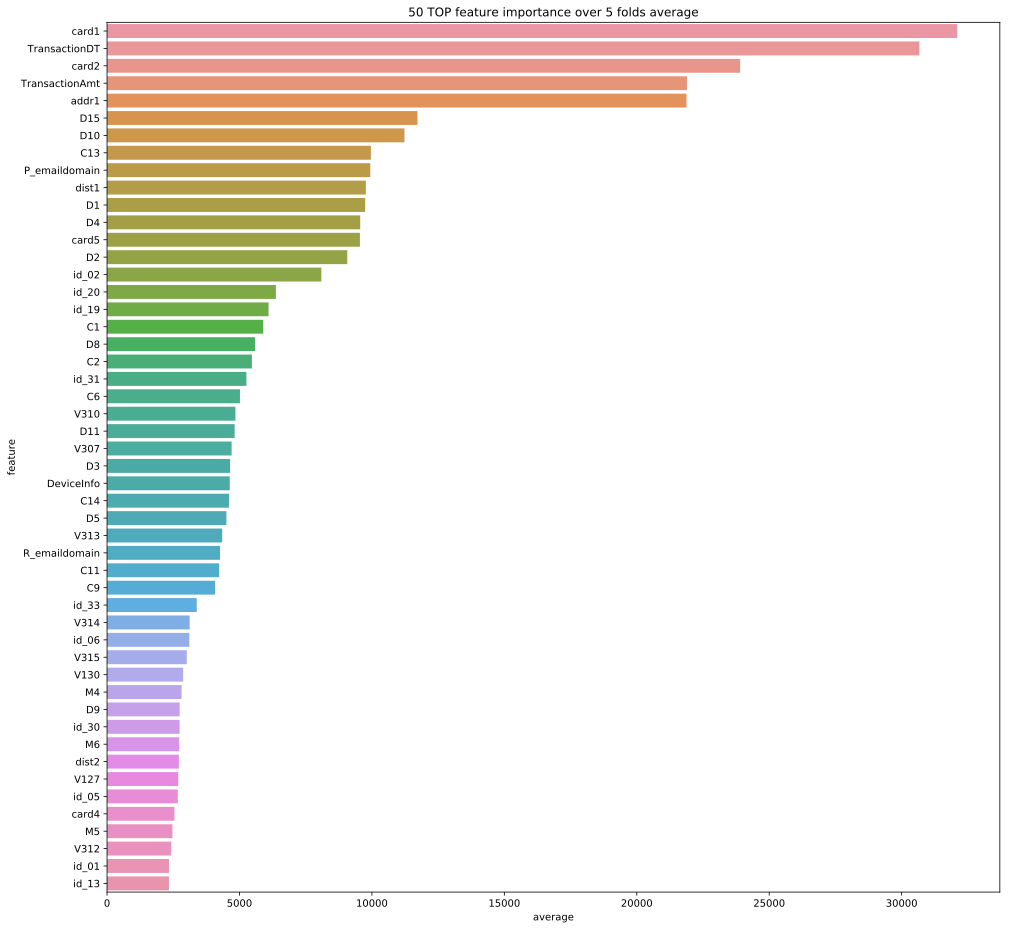

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns_pic = sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits))

In [49]:
fig = sns_pic.get_figure()
fig.savefig('D:/data/data_picture/ieee-cis_top_features.png') #保存文件

In [50]:
best_iter = clf.best_iteration

In [54]:
%%time

clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X_train, y_train)

D:\Selvaria\Anaconda\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.3797454081646243, importance_type='split',
        learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
        min_child_samples=20, min_child_weight=0.03454472573214212,
        min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_boost_round=1340, num_leaves=491,
        objective='binary', random_state=47, reg_alpha=0.3899927210061127,
        reg_lambda=0.6485237330340494, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [18]:
#

test_train = np.array([[1,2,3],  
                    [1,3,4],  
                    [2,1,2],  
                    [4,5,6],  
                    [3,5,3],  
                    [1,7,2]]) 
print(test_train.shape)
test_train[:,1]

(6, 3)


array([2, 3, 1, 5, 5, 7])

In [55]:
#预测，因为比赛是要求预测概率，使用predict_proba方法
#返回的是一个 n 行 k 列的数组， 第i行 第j列上的数值是模型预测 第 i 个预测样本为j列标签的概率，并且每一行的概率和为1。

sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1] #即返回第1列（标签为fraud的概率组成的列）
sample_submission.to_csv('d:/data/Kaggle/IEEE-CIS/simple_lgbm.csv')

In [19]:
sample_submission['other'] = clf.predict_proba(X_test)[:,0]
sample_submission.head()

,isFraud,other
TransactionID,,
3663549,0.003801,0.996199
3663550,0.001356,0.998644
3663551,0.003680,0.996320
3663552,0.002573,0.997427
3663553,0.001063,0.998937


In [20]:
%%time

from sklearn import linear_model

lm = linear_model.LogisticRegression()
lm.fit(X_train, y_train)

Wall time: 1min 32s


In [21]:
#逻辑回归分类

sample_submission = pd.read_csv('d:/data/Kaggle/IEEE-CIS/sample_submission.csv', index_col='TransactionID')

sample_submission['isFraud'] = lm.predict_proba(X_test)[:,1] #即返回第1列（标签为fraud的概率组成的列）
sample_submission.to_csv('d:/data/Kaggle/IEEE-CIS/logistic_regression.csv')

sample_submission.head()

,isFraud
TransactionID,
3663549,0.018773
3663550,0.023572
3663551,0.035241
3663552,0.023315
3663553,0.020394
